### Imports & GPU Selection

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import os
import gc
import re
from scipy.stats import wilcoxon

# SPECIFY GPU
device = torch.device("mps")

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BERT Fine-Tuning On PolitiFact (Human)

### Data Loading & Pre-Processing
- Tokenisation
- Analyse tokenised sequence length
- Data formatting

In [2]:
# Function to create tokenised text attention masks & labels in tensor format
def pre_process_data(data, tokenizer, max_len):
    text = data['text']
    labels = data['is_true']

    untruncated_tokenised_sequences = [(tokenizer.encode(text, truncation=False, add_special_tokens=True)) for text in text]

    tokenised_sequences = tokenizer.batch_encode_plus(
    text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True)

    tokenised_sequence_tensor = torch.tensor(tokenised_sequences['input_ids'])
    mask_tensor = torch.tensor(tokenised_sequences['attention_mask'])
    labels_tensor = torch.tensor(labels.tolist())

    return untruncated_tokenised_sequences, tokenised_sequence_tensor, mask_tensor, labels_tensor

In [3]:
# Define tokeniser & truncation max length
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_len = 256

# Load data
train_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_train.csv")
val_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_validation.csv")
test_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_test.csv")

# Obtain tokenised text, attention masks & labels in tensor format
train_untruncated_seq, train_seq, train_mask, train_y = pre_process_data(train_df, tokenizer, max_len)
val_untruncated_seq, val_seq, val_mask, val_y = pre_process_data(val_df, tokenizer, max_len)
test_untruncated_seq, test_seq, test_mask, test_y = pre_process_data(test_df, tokenizer, max_len)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (5466 > 512). Running this sequence through the model will result in indexing errors
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific len

max:22952
min:8


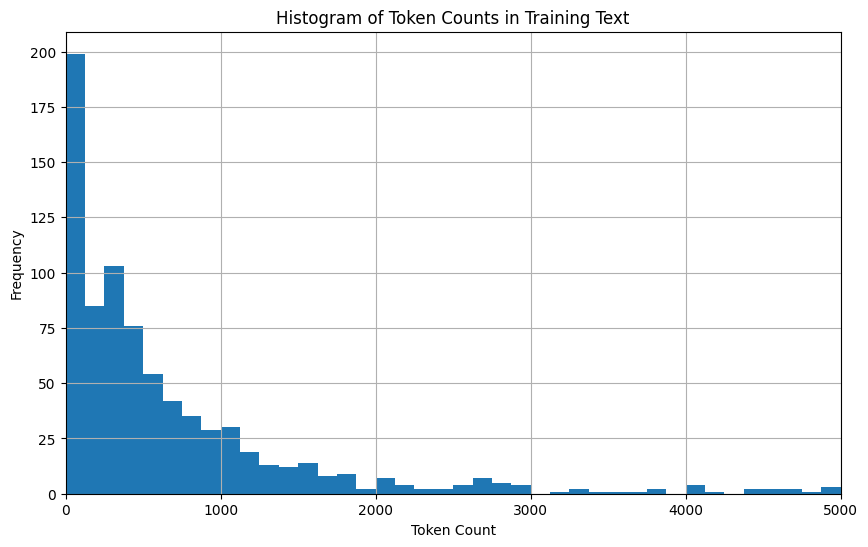

In [4]:
# Plot the histogram of untruncated token counts
all_tokenised_seq = train_untruncated_seq + val_untruncated_seq + test_untruncated_seq
token_counts = [len(seq) for seq in all_tokenised_seq]
print('max:' + str(max(token_counts)))
print('min:' + str(min(token_counts)))
plt.figure(figsize=(10, 6))
pd.Series(token_counts).hist(bins=200, range=(0, 25000))
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts in Tokenised PolitiFact Human Data')
plt.xlim(0, 5000)
plt.show()

## Define Model Architecture

In [5]:
# Define frozen BERT model
def initialise_bert_model():
    # Load original BERT and freeze its parameters
    bert = AutoModel.from_pretrained('bert-base-uncased')
    for param in bert.parameters():
        param.requires_grad = False

    # Define the model architecture with classification head
    # Classification head: ReLu -> FC -> ReLu -> FC -> Softmax
    class BERT_Arch(nn.Module):

        # Define layers within the model (we use these layers in the forward pass)
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            self.dropout = nn.Dropout(0.1)
            self.relu = nn.ReLU()
            self.fc1 = nn.Linear(768, 512)
            self.fc2 = nn.Linear(512, 2)
            self.softmax = nn.LogSoftmax(dim=1)

        # Define forward pass (flow of data) through network
        def forward(self, sent_id, mask):
            # Pass the CLS token (BERT's output) to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.softmax(x)
            return x

    # Create an instance of BERT and place on GPU
    model = BERT_Arch(bert)
    model = model.to(device)

    return model

In [6]:
# Define unfrozen BERT model
def initialise_bert_model_unfrozen():
    # Load original BERT and freeze its parameters
    bert = AutoModel.from_pretrained('bert-base-uncased')
    for param in bert.parameters():
        param.requires_grad = True

    # Define the model architecture with classification head
    # Classification head: ReLu -> FC -> ReLu -> FC -> Softmax
    class BERT_Arch(nn.Module):

        # Define layers within the model (we use these layers in the forward pass)
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            self.dropout = nn.Dropout(0.1)
            self.relu = nn.ReLU()
            self.fc1 = nn.Linear(768, 512)
            self.fc2 = nn.Linear(512, 2)
            self.softmax = nn.LogSoftmax(dim=1)

        # Define forward pass (flow of data) through network
        def forward(self, sent_id, mask):
            # Pass the CLS token (BERT's output) to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.softmax(x)
            return x

    # Create an instance of BERT and place on GPU
    model = BERT_Arch(bert)
    model = model.to(device)

    return model

## Define Training & Evaluation Processes

In [7]:
# Define training function for BERT model
def train(loss_function, optimizer, train_dataloader,model):
    model.train()
    total_loss = 0
    total_preds = []
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        batch_loss = loss_function(preds, labels)
        total_loss += batch_loss.item()
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Define evaluation function for BERT model
def evaluate(loss_function, val_dataloader,model):
    print("\nEvaluating...")
    model.eval()
    total_loss = 0
    total_preds = []
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            batch_loss = loss_function(preds, labels)
            total_loss += batch_loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

## Hyperparameter Selection Using Validation Set

In [8]:
# Define path to save / load model weights
model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_validation.pt"

# RUN THIS CODE TO RERUN HYPERPARAMETER TUNING
'''
os.remove(model_path)
'''

'\nos.remove(model_path)\n'

In [9]:
# Function to perform Hyperparameter selection using grid search
def hyper_param_selection(learning_rates, batch_sizes, epochs_options, model_inits, train_seq, train_mask, train_y, val_seq, val_mask, val_y):

    # Calculate class weights
    train_y_numpy = train_y.numpy()
    train_y_pd = pd.DataFrame(train_y_numpy)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_y_pd),
        y=train_y_pd)
    class_weights_tensor= torch.tensor(class_weights, dtype=torch.float).to(device)

    # Initialize variables to store the best model's performance and hyperparameters
    best_valid_loss = float('inf')
    best_hyperparams = {'lr': None, 'batch_size': None, 'epochs': None, 'model_init': None}

    # Check if model weights file already exists
    if os.path.exists(model_path):
        print(f"Model weights already saved at {model_path}. Skipping hyperparameter selection.")
    else:
        for model_init in model_inits:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for epochs in epochs_options:
                        
                        if model_init=="unfrozen":
                            model = initialise_bert_model_unfrozen()
                        else:
                            model = initialise_bert_model()
                        optimizer = optim.AdamW(model.parameters(), lr=lr)
                        weighted_cross_entropy = nn.NLLLoss(weight=class_weights_tensor)
                        
                        print(f"\nTraining with model={model_init}, lr={lr}, batch_size={batch_size}, epochs={epochs}")
                        train_dataloader = DataLoader(TensorDataset(train_seq, train_mask, train_y), 
                                                    sampler=RandomSampler(TensorDataset(train_seq, train_mask, train_y)), 
                                                    batch_size=batch_size)
                        val_dataloader = DataLoader(TensorDataset(val_seq, val_mask, val_y), 
                                                    sampler=SequentialSampler(TensorDataset(val_seq, val_mask, val_y)), 
                                                    batch_size=batch_size)

                        for epoch in range(epochs):
                            print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
                            train_loss, _ = train(loss_function=weighted_cross_entropy, optimizer=optimizer, train_dataloader=train_dataloader, model=model)
                            valid_loss, _ = evaluate(loss_function=weighted_cross_entropy, val_dataloader=val_dataloader, model=model)
                            if valid_loss < best_valid_loss:
                                best_valid_loss = valid_loss
                                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs, 'model_init': model_init}
                                torch.save(model.state_dict(), model_path)
                                print(f"Saved new best weights to {model_path}")
                            print(f'\nTraining Loss: {train_loss:.3f}')
                            print(f'Validation Loss: {valid_loss:.3f}')

        print(f"\nBest Hyperparameters: Model = {best_hyperparams['model_init']}, Learning Rate = {best_hyperparams['lr']}, Batch Size = {best_hyperparams['batch_size']}, Epochs = {best_hyperparams['epochs']}")
        print(f"Best model saved to: {model_path}")

    return best_hyperparams

In [10]:
# Define hyperparameter search grid
learning_rates = [1e-5, 5e-5]
batch_sizes = [16]
epochs_options = [2, 4]
model_inits = ["unfrozen", "frozen"]

# Run hyperparameter selection (this code will not run if model weights already exist as we have already performed this step)
hyper_param_selection(learning_rates=learning_rates, batch_sizes=batch_sizes, epochs_options=epochs_options, model_inits=model_inits, train_seq=train_seq, train_mask=train_mask, train_y=train_y, val_seq=val_seq, val_mask=val_mask, val_y=val_y)

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_validation.pt. Skipping hyperparameter selection.


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': None, 'batch_size': None, 'epochs': None, 'model_init': None}

## Fine Tune Using Chosen Hyperparameters On Train Union Validation

In [11]:
# Define path to save / load model weights
model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_finetuned.pt"

# RUN THIS CODE TO RERUN FINE-TUNING
'''
os.remove(model_path)
'''

'\nos.remove(model_path)\n'

In [12]:
# Function to fine-tune the model on chosen hyperparameters
def fine_tune(training_sequence, training_mask, training_y, epochs, batch_size, lr, model_init, model_path):
    training_y_numpy = training_y.numpy()
    training_y_pd = pd.DataFrame(training_y_numpy)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(training_y_pd),
        y=training_y_pd)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    if os.path.exists(model_path):
        print(f"Model weights already saved at {model_path}. Skipping training.")
    else:
        # DataLoader for the combined dataset
        training_dataloader = DataLoader(TensorDataset(training_sequence, training_mask, training_y), 
                                        sampler=RandomSampler(TensorDataset(training_sequence, training_mask, training_y)), 
                                        batch_size=batch_size)

        if model_init=="unfrozen":
            model = initialise_bert_model_unfrozen()
        else:
            model = initialise_bert_model()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        cross_entropy = nn.NLLLoss(weight=weights)

        # Model training loop
        for epoch in range(epochs):
            print(f'\n Epoch {epoch + 1} / {epochs}')
            train_loss = 0
            model.train()
            for step, batch in enumerate(training_dataloader):
                batch = [item.to(device) for item in batch]
                seq, mask, labels = batch
                model.zero_grad()
                outputs = model(seq, mask)
                loss = cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Log the average loss of the epoch
            avg_train_loss = train_loss / len(training_dataloader)
            print(f'\nAverage Training Loss: {avg_train_loss:.3f}')

        # Save the trained model weights
        torch.save(model.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

In [13]:
# Define best hyperparameters as chosen by previous hyperparameter selection grid search
best_lr = 5e-5
best_batch_size = 16
best_epochs = 2
best_model_init = "unfrozen"

# Combine training and validation data for fine-tuning
combined_training_sequence = torch.cat((train_seq, val_seq), 0)
combined_training_mask = torch.cat((train_mask, val_mask), 0)
combined_training_y = torch.cat((train_y, val_y), 0)

# Fine-tune the model
fine_tune(training_sequence=combined_training_sequence, training_mask=combined_training_mask, training_y=combined_training_y, epochs=best_epochs, batch_size=best_batch_size, lr=best_lr, model_init=best_model_init, model_path=model_path)

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_finetuned.pt. Skipping training.


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Predict Labels On Test Set & LLM Set

In [14]:
# Load the fine-tuned model
model=initialise_bert_model_unfrozen()
model.load_state_dict(torch.load(model_path), strict=False)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

_IncompatibleKeys(missing_keys=[], unexpected_keys=['bert.embeddings.position_ids'])

In [15]:
# Function to predict labels and compute performance metrics using batching
def predictions_and_metrics_basic(model, original_df, sequences, masks, labels):
    model = model.to(device)
    model.eval()
    all_preds = []
    batch_size = 32

    n_batches = (len(sequences) + batch_size - 1) // batch_size
    print(f"Total batches to process: {n_batches}")
    
    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            seq_batch = sequences[i:i+batch_size].to(device)
            mask_batch = masks[i:i+batch_size].to(device)
            
            preds = model(seq_batch, mask_batch)
            preds = preds.detach().cpu().numpy()
            all_preds.append(preds)

            
            # Progress update every 10 batches
            if (i // batch_size + 1) % 10 == 0:
                processed_batches = i // batch_size + 1
                remaining_batches = n_batches - processed_batches
                print(f"Processed {processed_batches} batches, {remaining_batches} batches remaining")
    
    all_preds=np.concatenate(all_preds, axis=0)
    predictions = np.argmax(all_preds, axis=1)

    text = original_df['text']
    text_pd = pd.DataFrame(text)
    text_pd = text_pd.iloc[:,0]

    labels_numpy = labels.numpy()
    labels_pd = pd.DataFrame(labels_numpy)
    labels_pd = labels_pd.iloc[:,0]

    results_df = pd.DataFrame({'Text': text_pd, 'Predicted Label': predictions, 'Original Label': labels_pd})
    results_df = results_df.dropna(subset=['Text'])

    original_misinformations = results_df[results_df['Original Label'] == 0]
    correct_predictions = original_misinformations[original_misinformations['Predicted Label'] == 0].shape[0]
    success_rate = 100*(correct_predictions / original_misinformations.shape[0]) if original_misinformations.shape[0] > 0 else 0

    metrics = classification_report(labels, predictions)
    
    return results_df, success_rate, metrics


# Function to predict labels and compute performance metrics using batching
# This function also outputs classwise success rates (for different LLMFake categories)
def predictions_and_metrics_classwise(model, original_df, sequences, masks, labels):
    model = model.to(device)
    model.eval()
    all_preds = []
    batch_size = 32

    n_batches = (len(sequences) + batch_size - 1) // batch_size
    print(f"Total batches to process: {n_batches}")
    
    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            seq_batch = sequences[i:i+batch_size].to(device)
            mask_batch = masks[i:i+batch_size].to(device)
            
            preds = model(seq_batch, mask_batch)
            preds = preds.detach().cpu().numpy()
            all_preds.append(preds)

            # Progress update every 10 batches
            if (i // batch_size + 1) % 10 == 0:
                processed_batches = i // batch_size + 1
                remaining_batches = n_batches - processed_batches
                print(f"Processed {processed_batches} batches, {remaining_batches} batches remaining")
    
    all_preds = np.concatenate(all_preds, axis=0)
    predictions = np.argmax(all_preds, axis=1)

    text = original_df['text']
    text_pd = pd.DataFrame(text)
    text_pd = text_pd.iloc[:, 0]

    labels_numpy = labels.numpy()
    labels_pd = pd.DataFrame(labels_numpy)
    labels_pd = labels_pd.iloc[:, 0]

    categories = original_df['label']
    categories_pd = pd.DataFrame(categories)
    categories_pd = categories_pd.iloc[:, 0]

    results_df = pd.DataFrame({
        'Text': text_pd,
        'Category': categories_pd,
        'Predicted Label': predictions,
        'Original Label': labels_pd
    })
    results_df = results_df.dropna(subset=['Text'])

    # Compute overall success rate
    original_misinformations = results_df[results_df['Original Label'] == 0]
    correct_predictions = original_misinformations[original_misinformations['Predicted Label'] == 0].shape[0]
    success_rate = 100 * (correct_predictions / original_misinformations.shape[0]) if original_misinformations.shape[0] > 0 else 0

    # Compute class-wise success rates
    classwise_success_rates = {}
    for category in results_df['Category'].unique():
        category_df = results_df[results_df['Category'] == category]
        original_misinformations = category_df[category_df['Original Label'] == 0]
        correct_predictions = original_misinformations[original_misinformations['Predicted Label'] == 0].shape[0]
        classwise_success_rate = 100 * (correct_predictions / original_misinformations.shape[0]) if original_misinformations.shape[0] > 0 else 0
        classwise_success_rates[category] = classwise_success_rate

    metrics = classification_report(labels, predictions)
    
    return results_df, success_rate, classwise_success_rates, metrics

In [16]:
# Human trained BERT on human test set
# Obtain performance metrics
results_df, success_rate, metrics = predictions_and_metrics_basic(model=model, original_df=test_df, sequences=test_seq, masks=test_mask, labels=test_y)
print(metrics)
print(f"Success rate: {success_rate:.2f}%")

# Save predictions to file if the file does not already exist
results_table_path = '/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_bert.csv'
if os.path.exists(results_table_path):
    print(f"{results_table_path} already exists. The DataFrame will not be saved.")
else:
    # Save the results_df to the results_table_path
    results_df.to_csv(results_table_path, index=False)
    print(f"Results DataFrame saved to {results_table_path}.")

Total batches to process: 6
              precision    recall  f1-score   support

           0       0.84      0.89      0.87        76
           1       0.92      0.87      0.89       100

    accuracy                           0.88       176
   macro avg       0.88      0.88      0.88       176
weighted avg       0.88      0.88      0.88       176

Success rate: 89.47%
/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_bert.csv already exists. The DataFrame will not be saved.


In [17]:
# Human trained BERT on LLMFake test set
# Load & pre-process test data
ood_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_test.csv")
ood_untruncated_seq, ood_seq, ood_mask, ood_y = pre_process_data(ood_df, tokenizer, max_len)

# Obtain performance metrics
results_df, success_rate, classwise_success_rates, metrics = predictions_and_metrics_classwise(model=model, original_df=ood_df, sequences=ood_seq, masks=ood_mask, labels=ood_y)
print(metrics)
print(f"Success rate: {success_rate:.2f}%")
print(classwise_success_rates)

results_table_path = '/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_bert.csv'
if os.path.exists(results_table_path):
    print(f"{results_table_path} already exists. The DataFrame will not be saved.")
else:
    # Save the results_df to the results_table_path
    results_df.to_csv(results_table_path, index=False)
    print(f"Results DataFrame saved to {results_table_path}.")

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific leng

Total batches to process: 14
Processed 10 batches, 4 batches remaining
              precision    recall  f1-score   support

           0       1.00      0.66      0.80       417
           1       0.00      0.00      0.00         0

    accuracy                           0.66       417
   macro avg       0.50      0.33      0.40       417
weighted avg       1.00      0.66      0.80       417

Success rate: 66.19%
{'llm_totally_arbitrary_generation': 100.0, 'llm_incomplete': 34.48275862068966, 'llm_false_context': 40.0, 'llm_open_generation': 90.74074074074075, 'llm_unsubstantiated_content': 37.93103448275862, 'llm_outdated': 34.48275862068966, 'llm_health_generation': 100.0, 'llm_rewritten': 92.5925925925926, 'llm_total_fabrication': 44.827586206896555, 'llm_politics_generation': 100.0, 'llm_paraphrase': 87.03703703703704, 'llm_hallucination': 45.0, 'llm_ambiguity': 17.24137931034483}
/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_bert.csv alre

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT Fine-Tuning On PolitiFact (Human & LLM)

### Data Loading & Pre-Processing
- Tokenisation
- Analyse tokenised sequence length
- Data formatting

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


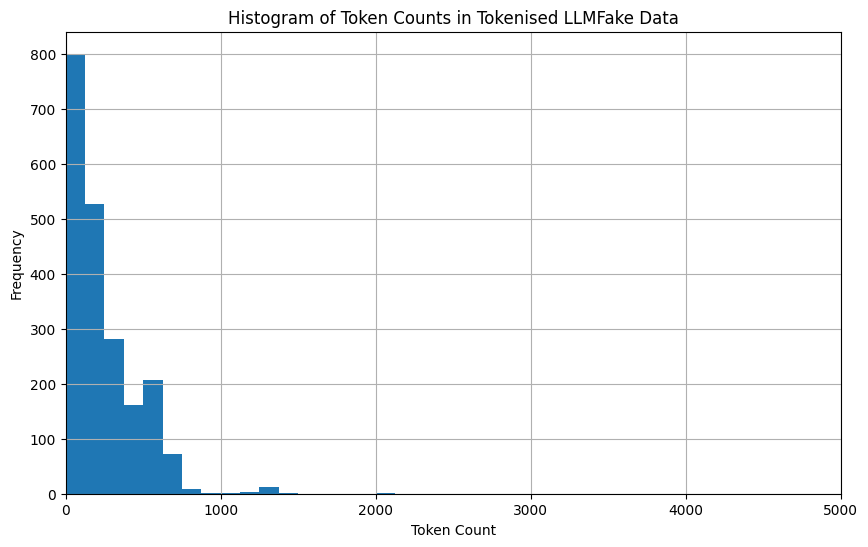

In [38]:
# Load data
train_human_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_train.csv")
val_human_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_validation.csv")
test_human_df = pd.read_csv("/Applications/AI/msc_project/data/my_politifact_test.csv")
train_llm_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_train.csv")
val_llm_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_validation.csv")
test_llm_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_test.csv")

# Combine Human & LLMFake datasets
filtered_train_llm_df = train_llm_df[['text', 'is_true']]
combined_train_df = pd.concat([train_human_df, filtered_train_llm_df], ignore_index=True)
filtered_val_llm_df = val_llm_df[['text', 'is_true']]
combined_val_df = pd.concat([val_human_df, filtered_val_llm_df], ignore_index=True)
filtered_test_llm_df = test_llm_df[['text', 'is_true']]
combined_test_df = pd.concat([test_human_df, filtered_test_llm_df], ignore_index=True)

# Pre-process data
train_untruncated_seq, train_seq, train_mask, train_y = pre_process_data(combined_train_df, tokenizer, max_len)
val_untruncated_seq, val_seq, val_mask, val_y = pre_process_data(combined_val_df, tokenizer, max_len)
test_untruncated_seq, test_seq, test_mask, test_y = pre_process_data(combined_test_df, tokenizer, max_len)


# Plot the histogram of token counts of tokenised text for LLMFake Data
train_llm_untruncated_seq, train_llm_seq, train_llm_mask, train_llm_y = pre_process_data(filtered_train_llm_df, tokenizer, max_len)
val_llm_untruncated_seq, val_llm_seq, val_llm_mask, val_llm_y = pre_process_data(filtered_val_llm_df, tokenizer, max_len)
test_llm_untruncated_seq, test_llm_seq, test_llm_mask, test_llm_y = pre_process_data(filtered_test_llm_df, tokenizer, max_len)
all_llm_tokenised_seq = train_llm_untruncated_seq + val_llm_untruncated_seq + test_llm_untruncated_seq
llm_token_counts = [len(seq) for seq in all_llm_tokenised_seq]
plt.figure(figsize=(10, 6))
pd.Series(llm_token_counts).hist(bins=200, range=(0, 25000))
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts in Tokenised LLMFake Data')
plt.xlim(0, 5000)
plt.show()

## Hyperparameter Selection Using Validation Set

In [19]:
# Define model path
model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_validation.pt"

# RUN THIS CODE TO RERUN HYPERPARAMETER TUNING
'''
os.remove(model_path)
'''

'\nos.remove(model_path)\n'

In [20]:
# Define hyperparameter search grid
learning_rates = [1e-5, 5e-5]
batch_sizes = [16]
epochs_options = [2, 4]
model_inits = ["unfrozen", "frozen"]

# Run hyperparameter selection (this code will not run if model weights already exist as we have already performed this step)
hyper_param_selection(learning_rates=learning_rates, batch_sizes=batch_sizes, epochs_options=epochs_options, model_inits=model_inits, train_seq=train_seq, train_mask=train_mask, train_y=train_y, val_seq=val_seq, val_mask=val_mask, val_y=val_y)

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_validation.pt. Skipping hyperparameter selection.


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': None, 'batch_size': None, 'epochs': None, 'model_init': None}

DO BELOW (UPDATE TO MODERN)

## Fine Tune Using Chosen Hyperparameters On Train Union Validation

In [21]:
# Define model path
model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_llm_finetuned.pt"

# RUN THIS CODE TO RERUN FINE-TUNING
'''
os.remove(model_path)
'''

'\nos.remove(model_path)\n'

In [22]:
# Define best hyperparameters as chosen by previous hyperparameter selection grid search
best_lr = 1e-5
best_batch_size = 16
best_epochs = 2
best_model_init = "unfrozen"

# Combine training and validation data for fine-tuning
combined_training_sequence = torch.cat((train_seq, val_seq), 0)
combined_training_mask = torch.cat((train_mask, val_mask), 0)
combined_training_y = torch.cat((train_y, val_y), 0)

# Fine-tune the model
fine_tune(training_sequence=combined_training_sequence, training_mask=combined_training_mask, training_y=combined_training_y, epochs=best_epochs, batch_size=best_batch_size, lr=best_lr, model_init=best_model_init, model_path=model_path)

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_llm_finetuned.pt. Skipping training.


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Predict Labels On Test Set & LLM Set

In [23]:
# Load the fine-tuned model
model=initialise_bert_model_unfrozen()
model.load_state_dict(torch.load(model_path), strict=False)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

_IncompatibleKeys(missing_keys=[], unexpected_keys=['bert.embeddings.position_ids'])

In [24]:
# Human and LLMFake trained BERT on human test set
# Obtain performance metrics
results_df, success_rate, metrics = predictions_and_metrics_basic(model=model, original_df=test_df, sequences=test_seq, masks=test_mask, labels=test_y)
print(metrics)
print(f"Success rate: {success_rate:.2f}%")

results_table_path = '/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_and_llm_bert.csv'
if os.path.exists(results_table_path):
    print(f"{results_table_path} already exists. The DataFrame will not be saved.")
else:
    # Save the results_df to the results_table_path
    results_df.to_csv(results_table_path, index=False)
    print(f"Results DataFrame saved to {results_table_path}.")

Total batches to process: 19
Processed 10 batches, 9 batches remaining
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       493
           1       0.74      0.89      0.81       100

    accuracy                           0.93       593
   macro avg       0.86      0.91      0.88       593
weighted avg       0.94      0.93      0.93       593

Success rate: 82.89%
/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_and_llm_bert.csv already exists. The DataFrame will not be saved.


In [25]:
# Human and LLMFake trained BERT on LLMFake test set
# Load & pre-process test data
ood_df = pd.read_csv("/Applications/AI/msc_project/data/my_llm_fake_politifact_test.csv")
ood_untruncated_seq, ood_seq, ood_mask, ood_y = pre_process_data(ood_df, tokenizer, max_len)

# Obtain performance metrics
results_df, success_rate, classwise_success_rates, metrics = predictions_and_metrics_classwise(model=model, original_df=ood_df, sequences=ood_seq, masks=ood_mask, labels=ood_y)
print(metrics)
print(f"Success rate: {success_rate:.2f}%")
print(classwise_success_rates)

results_table_path = '/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_and_llm_bert.csv'
if os.path.exists(results_table_path):
    print(f"{results_table_path} already exists. The DataFrame will not be saved.")
else:
    # Save the results_df to the results_table_path
    results_df.to_csv(results_table_path, index=False)
    print(f"Results DataFrame saved to {results_table_path}.")

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific leng

Total batches to process: 14
Processed 10 batches, 4 batches remaining
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       417
           1       0.00      0.00      0.00         0

    accuracy                           0.95       417
   macro avg       0.50      0.48      0.49       417
weighted avg       1.00      0.95      0.98       417

Success rate: 95.44%
{'llm_totally_arbitrary_generation': 100.0, 'llm_incomplete': 89.65517241379311, 'llm_false_context': 96.66666666666667, 'llm_open_generation': 98.14814814814815, 'llm_unsubstantiated_content': 93.10344827586206, 'llm_outdated': 96.55172413793103, 'llm_health_generation': 100.0, 'llm_rewritten': 98.14814814814815, 'llm_total_fabrication': 89.65517241379311, 'llm_politics_generation': 100.0, 'llm_paraphrase': 98.14814814814815, 'llm_hallucination': 100.0, 'llm_ambiguity': 79.3103448275862}
/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------

## Resampling (Human BERT)
- We train and evaluate BERT on 5 different train and test sets to obtain 5 sets of performance metrics for statistical hypothesis testing

In [26]:
# Function to fine-tune multiple models
def resample_training_models(model_paths, train_processed_seq_list, train_processed_mask_list, train_processed_y_list, model_init, epochs, batch_size, lr):

    for i in range(len(model_paths)):

        model_path = model_paths[i]
        if os.path.exists(model_path):
            print(f"Model weights already saved at {model_path}. Skipping training.")
            continue

        fine_tune(training_sequence=train_processed_seq_list, training_mask=train_processed_mask_list, training_y=train_processed_y_list, epochs=epochs, batch_size=batch_size, lr=lr, model_init=model_init, model_path=model_path)

In [27]:
# Function to pre-process multiple datasets
def pre_process_multi_datasplits(data_list,tokenizer,max_len):
    processed_seq_list=[]
    processed_mask_list=[]
    processed_y_list=[]
    for i in range(len(data_list)):
        dataset = pd.read_csv(data_list[i])
        _, dataset_seq, dataset_mask, dataset_y = pre_process_data(dataset, tokenizer, max_len)
        processed_seq_list.append(dataset_seq)
        processed_mask_list.append(dataset_mask)
        processed_y_list.append(dataset_y)

    return processed_seq_list, processed_mask_list, processed_y_list

In [28]:
# Function to obtain performance metrics from multiple models on multiple datasets
def obtain_resampled_metrics_lists(models_list, original_df_list, sequences_list, masks_list, labels_list):

    success_rate_list=[]
    macro_f1_list=[]
    for i in range(len(models_list)):
        _, success_rate, metrics = predictions_and_metrics_basic(models_list[i],original_df_list[i],sequences_list[i],masks_list[i],labels_list[i])
        macro_f1_score = float(re.search(r'^\s*macro avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', metrics, re.MULTILINE).group(1))

        success_rate_list.append(success_rate)
        macro_f1_list.append(macro_f1_score)

    return success_rate_list,macro_f1_list

# Function to obtain performance metrics from multiple models on multiple datasets
# This function also outputs classwise success rates (for different LLMFake categories)
def obtain_resampled_metrics_lists_classwise(models_list, original_df_list, sequences_list, masks_list, labels_list):
    success_rate_list = []
    macro_f1_list = []
    all_classwise_success_rates = {}

    for i in range(len(models_list)):
        _, success_rate, classwise_success_rates, metrics = predictions_and_metrics_classwise(
            models_list[i], original_df_list[i], sequences_list[i], masks_list[i], labels_list[i]
        )
        macro_f1_score = float(re.search(r'^\s*macro avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', metrics, re.MULTILINE).group(1))

        success_rate_list.append(success_rate)
        macro_f1_list.append(macro_f1_score)
        
        for category, rate in classwise_success_rates.items():
            if category not in all_classwise_success_rates:
                all_classwise_success_rates[category] = []
            all_classwise_success_rates[category].append(rate)

    return success_rate_list, macro_f1_list, all_classwise_success_rates

In [29]:
# Define model weight file paths
model_path_1 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv1.pt"
model_path_2 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv2.pt"
model_path_3 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv3.pt"
model_path_4 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv4.pt"
model_path_5 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv5.pt"
model_paths = [model_path_1, model_path_2, model_path_3, model_path_4, model_path_5]

# RUN THIS CODE TO RERUN RESAMPLED FINE-TUNING EVALUATION
'''
os.remove(model_path_1)
os.remove(model_path_2)
os.remove(model_path_3)
os.remove(model_path_4)
os.remove(model_path_5)
'''

# Load & pre-process training data
train_path_1 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_1.csv"
train_path_2 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_2.csv"
train_path_3 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_3.csv"
train_path_4 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_4.csv"
train_path_5 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_5.csv"
train_splits = [train_path_1, train_path_2, train_path_3, train_path_4, train_path_5]
train_processed_seq_list, train_processed_mask_list, train_processed_y_list = pre_process_multi_datasplits(data_list=train_splits, tokenizer=tokenizer, max_len=max_len)

# Define best hyperparameters as chosen by previous hyperparameter selection grid search on initial exploration
best_lr = 5e-5
best_batch_size = 16
best_epochs = 2
best_model_init = "unfrozen"

# Fine-tune models
resample_training_models(model_paths=model_paths, train_processed_seq_list=train_processed_seq_list, train_processed_mask_list=train_processed_mask_list, train_processed_y_list=train_processed_y_list, model_init=best_model_init, epochs=best_epochs, batch_size=best_batch_size, lr=best_lr)

# Initialize and load these models
model_1 = initialise_bert_model_unfrozen()
model_1.load_state_dict(torch.load(model_path_1), strict=False)
model_2 = initialise_bert_model_unfrozen()
model_2.load_state_dict(torch.load(model_path_2), strict=False)
model_3 = initialise_bert_model_unfrozen()
model_3.load_state_dict(torch.load(model_path_3), strict=False)
model_4 = initialise_bert_model_unfrozen()
model_4.load_state_dict(torch.load(model_path_4), strict=False)
model_5 = initialise_bert_model_unfrozen()
model_5.load_state_dict(torch.load(model_path_5), strict=False)
models_list = [model_1, model_2, model_3, model_4, model_5]

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv1.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv2.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv3.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv4.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_cv5.pt. Skipping training.


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [30]:
# [RESAMPLING] Human trained BERT on human test set
test_path_1 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_1.csv"
test_path_2 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_2.csv"
test_path_3 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_3.csv"
test_path_4 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_4.csv"
test_path_5 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_5.csv"
test_splits = [test_path_1, test_path_2, test_path_3, test_path_4, test_path_5]
test_processed_seq_list, test_processed_mask_list, test_processed_y_list = pre_process_multi_datasplits(data_list=test_splits, tokenizer=tokenizer, max_len=max_len)

original_df_1 = pd.read_csv(test_path_1)
original_df_2 = pd.read_csv(test_path_2)
original_df_3 = pd.read_csv(test_path_3)
original_df_4 = pd.read_csv(test_path_4)
original_df_5 = pd.read_csv(test_path_5)
original_df_list = [original_df_1, original_df_2, original_df_3, original_df_4, original_df_5]

success_rate_list, macro_f1_list = obtain_resampled_metrics_lists(models_list, original_df_list=original_df_list, sequences_list=test_processed_seq_list, masks_list=test_processed_mask_list, labels_list=test_processed_y_list)
print(success_rate_list)
print(macro_f1_list)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
[91.8918918918919, 88.75, 80.0, 94.20289855072464, 72.97297297297297]
[0.88, 0.9, 0.88, 0.83, 0.87]


In [32]:
# [RESAMPLED] Human trained BERT on LLMFake test set
# Note: macro F1 here doesn't make sense
test_path_1 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_1.csv"
test_path_2 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_2.csv"
test_path_3 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_3.csv"
test_path_4 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_4.csv"
test_path_5 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_5.csv"
test_splits = [test_path_1, test_path_2, test_path_3, test_path_4, test_path_5]
test_processed_seq_list, test_processed_mask_list, test_processed_y_list = pre_process_multi_datasplits(data_list=test_splits, tokenizer=tokenizer, max_len=max_len)

original_df_1 = pd.read_csv(test_path_1)
original_df_2 = pd.read_csv(test_path_2)
original_df_3 = pd.read_csv(test_path_3)
original_df_4 = pd.read_csv(test_path_4)
original_df_5 = pd.read_csv(test_path_5)
original_df_list = [original_df_1, original_df_2, original_df_3, original_df_4, original_df_5]

success_rate_list, _, classwise_success_rates = obtain_resampled_metrics_lists_classwise(models_list, original_df_list=original_df_list, sequences_list=test_processed_seq_list, masks_list=test_processed_mask_list, labels_list=test_processed_y_list)
print(success_rate_list)
print(classwise_success_rates)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining
[72.59615384615384, 64.42307692307693, 50.0, 78.36538461538461, 55.52884615384615]
{'llm_false_context': [34.48275862068966, 31.03448275862069, 24.137931034482758, 68.96551724137932, 31.03448275862069], 'llm_unsubstantiated_content': [44.827586206896555, 37.93103448275862, 27.586206896551722, 62.06896551724138, 41.37931034482759], 'llm_total_fabrication': [62.06896551724138, 44.827586206896555, 27.586206896551722, 68.96551724137932, 48.275862068965516], 'llm_incomplete': [41.37931034482759, 31.03448275862069, 20.689655172413794, 37.93103448275862, 17.24137931034483], 'llm_ambiguity': [34.48275862068966, 34.48275862068966, 13.793103448275861, 41.37931034482759, 41.37931034482759], 'llm_totally_arbitrary_generation': [100.0, 90.0, 95.0, 100.0, 95.0], 'llm_open_generation': [94.44444444444444, 90.74074074074075, 79.62962962962963, 100.0, 62.96296296296296], 'llm_paraphrase': [96.29629629629629, 90.74074074074075, 66.66

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Resampling (Human & LLMFake BERT)

In [33]:
# Define model weight file paths
model_path_1 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv1.pt"
model_path_2 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv2.pt"
model_path_3 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv3.pt"
model_path_4 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv4.pt"
model_path_5 = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv5.pt"
model_paths = [model_path_1, model_path_2, model_path_3, model_path_4, model_path_5]

# RUN THIS CODE TO RERUN RESAMPLED FINE-TUNING EVALUATION
'''
os.remove(model_path_1)
os.remove(model_path_2)
os.remove(model_path_3)
os.remove(model_path_4)
os.remove(model_path_5)
'''

# Load & pre-process training data
human_train_path_1 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_1.csv"
human_train_path_2 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_2.csv"
human_train_path_3 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_3.csv"
human_train_path_4 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_4.csv"
human_train_path_5 = "/Applications/AI/msc_project/data/my_human_politifact_train_split_5.csv"
human_train_splits = [train_path_1, train_path_2, train_path_3, train_path_4, train_path_5]
human_train_processed_seq_list, human_train_processed_mask_list, human_train_processed_y_list = pre_process_multi_datasplits(data_list=human_train_splits, tokenizer=tokenizer, max_len=max_len)
llm_train_path_1 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_train_split_1.csv"
llm_train_path_2 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_train_split_2.csv"
llm_train_path_3 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_train_split_3.csv"
llm_train_path_4 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_train_split_4.csv"
llm_train_path_5 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_train_split_5.csv"
llm_train_splits = [llm_train_path_1, llm_train_path_2, llm_train_path_3, llm_train_path_4, llm_train_path_5]
llm_train_processed_seq_list, llm_train_processed_mask_list, llm_train_processed_y_list = pre_process_multi_datasplits(data_list=llm_train_splits, tokenizer=tokenizer, max_len=max_len)
combined_training_sequence_list = torch.cat((train_seq, val_seq), 0)
combined_training_mask_list = torch.cat((train_mask, val_mask), 0)
combined_training_y_list = torch.cat((train_y, val_y), 0)

# Define best hyperparameters as chosen by previous hyperparameter selection grid search on initial exploration
best_lr = 1e-5
best_batch_size = 16
best_epochs = 2
best_model_init = "unfrozen"

# Fine-tune models
resample_training_models(model_paths=model_paths, train_processed_seq_list=combined_training_sequence_list, train_processed_mask_list=combined_training_mask_list, train_processed_y_list=combined_training_y_list, model_init=best_model_init, epochs=best_epochs, batch_size=best_batch_size, lr=best_lr)

# Initialize and load models
model_1 = initialise_bert_model_unfrozen()
model_1.load_state_dict(torch.load(model_path_1), strict=False)
model_2 = initialise_bert_model_unfrozen()
model_2.load_state_dict(torch.load(model_path_2), strict=False)
model_3 = initialise_bert_model_unfrozen()
model_3.load_state_dict(torch.load(model_path_3), strict=False)
model_4 = initialise_bert_model_unfrozen()
model_4.load_state_dict(torch.load(model_path_4), strict=False)
model_5 = initialise_bert_model_unfrozen()
model_5.load_state_dict(torch.load(model_path_5), strict=False)
models_list = [model_1, model_2, model_3, model_4, model_5]

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv1.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv2.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv3.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv4.pt. Skipping training.
Model weights already saved at /Applications/AI/msc_project/model_weights/bert_weights_politifact_human_and_llm_cv5.pt. Skipping training.


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [34]:
# [RESAMPLING] Human & LLMFake trained BERT on human test set
test_path_1 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_1.csv"
test_path_2 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_2.csv"
test_path_3 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_3.csv"
test_path_4 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_4.csv"
test_path_5 = "/Applications/AI/msc_project/data/my_human_politifact_test_split_5.csv"
test_splits = [test_path_1, test_path_2, test_path_3, test_path_4, test_path_5]
test_processed_seq_list, test_processed_mask_list, test_processed_y_list = pre_process_multi_datasplits(data_list=test_splits, tokenizer=tokenizer, max_len=max_len)

original_df_1 = pd.read_csv(test_path_1)
original_df_2 = pd.read_csv(test_path_2)
original_df_3 = pd.read_csv(test_path_3)
original_df_4 = pd.read_csv(test_path_4)
original_df_5 = pd.read_csv(test_path_5)
original_df_list = [original_df_1, original_df_2, original_df_3, original_df_4, original_df_5]

success_rate_list, macro_f1_list = obtain_resampled_metrics_lists(models_list, original_df_list=original_df_list, sequences_list=test_processed_seq_list, masks_list=test_processed_mask_list, labels_list=test_processed_y_list)
print(success_rate_list)
print(macro_f1_list)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
Total batches to process: 6
[90.54054054054053, 71.25, 86.25, 72.46376811594203, 93.24324324324324]
[0.93, 0.86, 0.92, 0.87, 0.91]


In [35]:
# [RESAMPLED] Human & LLMFake trained BERT on LLMFake test set
# Note: macro F1 here doesn't make sense
test_path_1 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_1.csv"
test_path_2 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_2.csv"
test_path_3 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_3.csv"
test_path_4 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_4.csv"
test_path_5 = "/Applications/AI/msc_project/data/my_llm_fake_politifact_test_split_5.csv"
test_splits = [test_path_1, test_path_2, test_path_3, test_path_4, test_path_5]
test_processed_seq_list, test_processed_mask_list, test_processed_y_list = pre_process_multi_datasplits(data_list=test_splits, tokenizer=tokenizer, max_len=max_len)

original_df_1 = pd.read_csv(test_path_1)
original_df_2 = pd.read_csv(test_path_2)
original_df_3 = pd.read_csv(test_path_3)
original_df_4 = pd.read_csv(test_path_4)
original_df_5 = pd.read_csv(test_path_5)
original_df_list = [original_df_1, original_df_2, original_df_3, original_df_4, original_df_5]

success_rate_list, _, classwise_success_rates = obtain_resampled_metrics_lists_classwise(models_list, original_df_list=original_df_list, sequences_list=test_processed_seq_list, masks_list=test_processed_mask_list, labels_list=test_processed_y_list)
print(success_rate_list)
print(classwise_success_rates)

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) 

Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining


/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total batches to process: 13
Processed 10 batches, 3 batches remaining
[93.75, 93.02884615384616, 93.75, 93.02884615384616, 96.875]
{'llm_false_context': [79.3103448275862, 79.3103448275862, 79.3103448275862, 86.20689655172413, 96.55172413793103], 'llm_unsubstantiated_content': [82.75862068965517, 89.65517241379311, 86.20689655172413, 93.10344827586206, 100.0], 'llm_total_fabrication': [93.10344827586206, 89.65517241379311, 100.0, 86.20689655172413, 96.55172413793103], 'llm_incomplete': [86.20689655172413, 86.20689655172413, 82.75862068965517, 65.51724137931035, 79.3103448275862], 'llm_ambiguity': [82.75862068965517, 79.3103448275862, 79.3103448275862, 82.75862068965517, 96.55172413793103], 'llm_totally_arbitrary_generation': [100.0, 100.0, 100.0, 100.0, 100.0], 'llm_open_generation': [100.0, 98.14814814814815, 100.0, 100.0, 100.0], 'llm_paraphrase': [100.0, 98.14814814814815, 100.0, 100.0, 98.14814814814815], 'llm_outdated': [86.20689655172413, 82.75862068965517, 82.75862068965517, 96

/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobshort/anaconda3/envs/uni_39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
